## Análisis preliminar de datos

A continuación se presenta un primer análisis de los datos censales correspondientes a 2011.

Se utilizan varios conjuntos de datos disponibilizados en la web. Los datos censales corresponde a la información del Censo INE 2011 publicada en la web del Instituto. Se realiza un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso.

Como capas de información geográficas se toma las capas de polígonos de departamento sy de puntos de localidades del INE, identificando las capitales departamentales en esta última capa.

Se incluye una matriz de distancias entre cada capital departamental, calculada anteriormente con la API Google Distance Matriz.

El PBI departamental de toma de la información producida y publicada por OPP.

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely import wkt
from shapely.geometry import shape, LineString, Point

In [2]:
# rutas a datos
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'
pbi_url    = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/pbi_departamental.csv'
md_url     = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/df_distancias_centro_poblacion.csv'
deptos_url = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_deptos.gpkg'
local_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_localidades.gpkg'
cpobl_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/centro_poblacion.gpkg'

In [14]:
# carga datos desde GitHub

# Datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

# PBI departamental
pbi = pd.read_csv(pbi_url)

# matriz de distancias
md = pd.read_csv(md_url)
md.drop(['latlon_ori', 'latlon_des'], axis=1, inplace=True)

# carga capa departamentos INE pg
deptos = gpd.read_file(deptos_url)

# agrega centroides de departamentos
deptos['centroide'] = deptos['geometry'].centroid

# carga capa localidades INE pt
localidad = gpd.read_file(local_url)
localidad.CODLOC = localidad.CODLOC.astype(int)

# centro de población
centro_pobl = gpd.read_file(cpobl_url)

# filtra capitales departamentales de las localidades INE
capital = localidad[localidad.CAPITAL==True].reset_index(drop=True)

In [15]:
# calcula la población de cada departamento
poblacion = censo[['DPTO', 'LOC']].groupby(by=['DPTO']).count()
poblacion.rename(columns={'LOC': 'poblacion'}, inplace=True)

# genera dataframe con datos por departamento
datos_dpto = pd.merge(pbi, poblacion, on='DPTO')

**Análisis por departamentos**

Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personal del Censo INE 2011 se filtra según el siguiente criterio:
Variable "PERMI07" (lugar de residencia 5 años antes) con valores 2 (en otra localidad o paraje de este departamento) o 3 (en otro departamento). Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido empradronadas en el departamento de "destino" al momento de la aplicación del formulario censal.

In [33]:
# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# cambia DPTO a tipo entero
p_migr.DPTO = p_migr.DPTO.astype(int)

# print(p_migr.shape[0])

# Hay 26.449 residentes en localidades rurales
# print(p_migr[( p_migr.LOC == 900 )].shape[0])

# identifica depto de residencia anterior
p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')]
p_migr.depto_origen.fillna(p_migr.DPTO, inplace=True)

# convierte a string
p_migr.loc[:,('depto_origen')] = p_migr.loc[:,('depto_origen')].astype(int)

# renombra DPTO
p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

Se prefirió usar el centro medio de polbiación al centroide o la capital departamental.

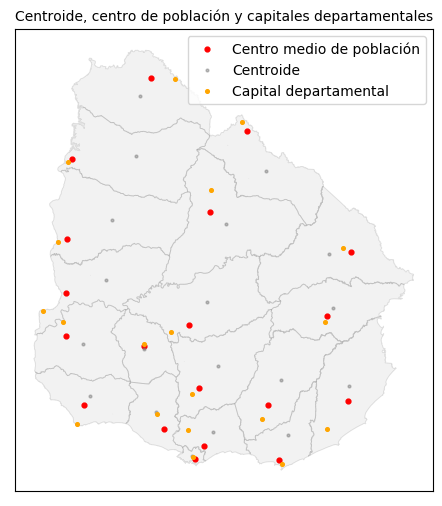

In [78]:
# plot de las capas de departamentos y localidades
plt.style.use('default')

f, ax = pl.subplots(figsize=(8,6))

# deptos
deptos.plot(linewidth = 0.7, edgecolor='black', color = 'grey', alpha=0.1, ax = ax)

# localidades
centro_pobl.plot(markersize=12, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=4, color = 'grey', alpha=0.5, ax = ax, label='Centroide')
capital.plot(markersize=7, color = 'orange', ax = ax, label='Capital departamental')

# oculta ejes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# título
pl.title("Centroide, centro de población y capitales departamentales", size=10)

# referencias
plt.legend()

In [79]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

A continuación se presentan dichos datos en formato de matriz simétrica, refiriéndose a cada departamento con su código INE.

In [80]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos, index ='depto_origen', columns='depto_destino', fill_value=0,
                        aggfunc=sum, margins=True, margins_name='Total',)
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

Se contruye un dataframe que contiene información para cada díada de departamentos. Los datos son los total de personas que declaran haber vivido antes en el departamento de origen, la población total en origen y destino, el PBI en el departamento de destino y la distancia. 

In [81]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo unico
df_agrupado.insert(0, 'cod', (df_agrupado['depto_origen'].astype(str)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2)).astype(int))
df_agrupado.head()

,cod,depto_origen,depto_destino,personas_mig
0,102,1,2,914
1,103,1,3,33127
2,104,1,4,1387
3,105,1,5,2100
4,106,1,6,982


In [84]:
merge1 = pd.merge(df_agrupado, datos_dpto[['DPTO', 'miles_de_pesos', 'poblacion']], left_on='depto_origen', right_on='DPTO')
merge2 = pd.merge(merge1, datos_dpto[['DPTO', 'miles_de_pesos', 'poblacion']], left_on='depto_destino', right_on='DPTO')
merge3 = pd.merge(merge2, md[['cod', 'distancia']], on='cod')
datos_diadas = merge3.drop(['DPTO_x', 'DPTO_y'], axis=1)
datos_diadas.head()

,cod,depto_origen,depto_destino,personas_mig,miles_de_pesos_x,poblacion_x,miles_de_pesos_y,poblacion_y,distancia
0,102,1,2,914,465848031,1318755,14214980,73377,610726
1,302,3,2,74,86306492,520173,14214980,73377,601916
2,402,4,2,15,17048887,84698,14214980,73377,406722
3,502,5,2,28,43788749,123203,14214980,73377,556293
4,602,6,2,32,13023942,57084,14214980,73377,446276


In [85]:
del(merge1, merge2, merge3)

datos_diadas.rename(columns={'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino',
                             'distancia': 'dist', 'poblacion_x': 'pob_origen', 'poblacion_y': 'pob_destino'},
                    inplace=True)

# destsal es el salario medio en destuno
# vamos a usar el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))
# logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))


datos_diadas.head()

,cod,depto_origen,depto_destino,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist
0,102,1,2,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404
1,302,3,2,74,86306492,520173,14214980,73377,601916,16.469807,13.307873
2,402,4,2,15,17048887,84698,14214980,73377,406722,16.469807,12.915885
3,502,5,2,28,43788749,123203,14214980,73377,556293,16.469807,13.229050
4,602,6,2,32,13023942,57084,14214980,73377,446276,16.469807,13.008693


In [86]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[flow_value]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica función
flows = odflow(datos_diadas,'depto_origen', 'depto_destino', 'personas_mig', deptos,'cod_ine')

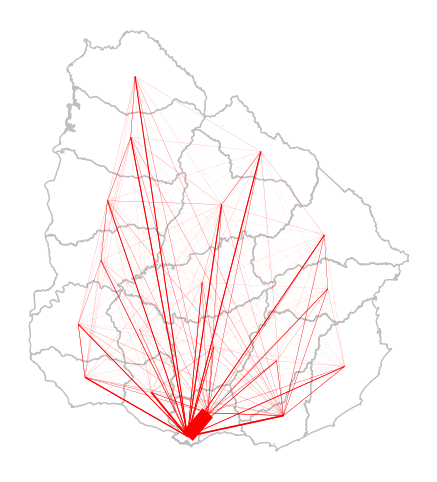

In [87]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='0.75',ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10,axis=1), color = 'red',ax=ax)
ax.set_aspect('equal')

Text(0.5, 0, 'Distancia (m)')

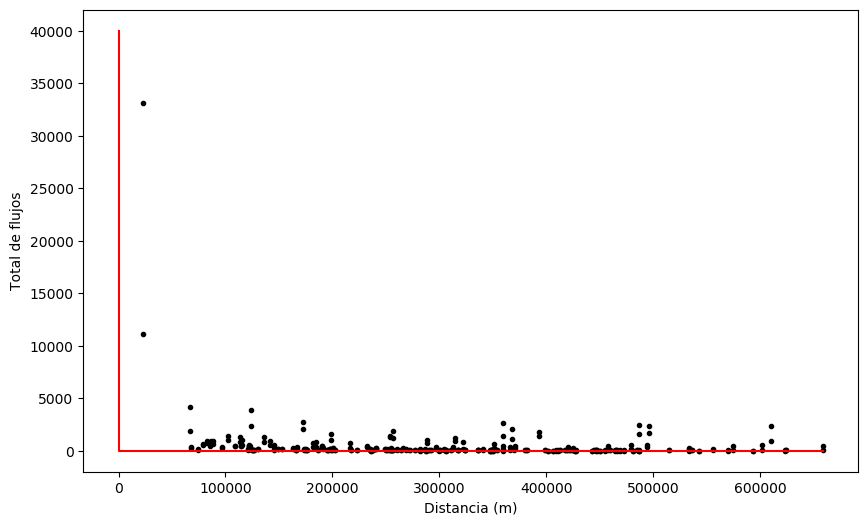

In [88]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.005, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Aetiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

Text(0.5, 0, 'Distancia (m)')

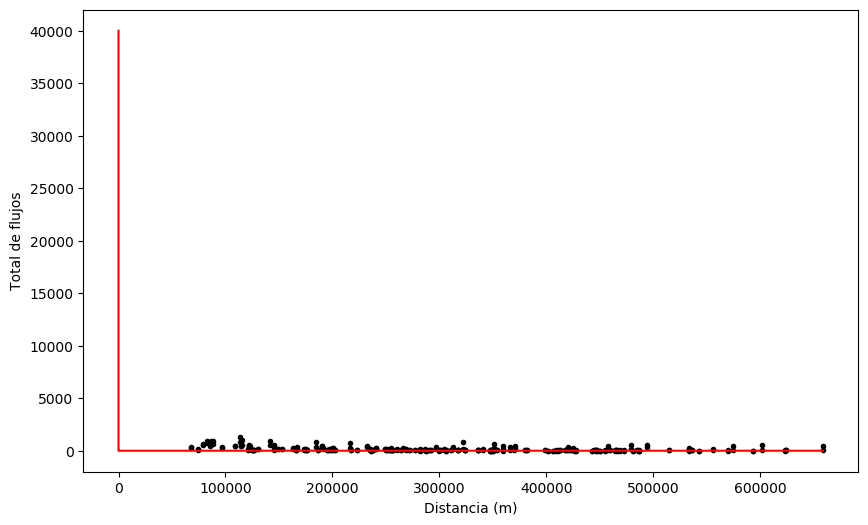

In [89]:
# mismo gráfico sin Mvdeo.
sin_mvo = datos_diadas[(datos_diadas['depto_origen'] > 1) & (datos_diadas['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist'], sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.005, sin_mvo['dist'].max(), 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Aetiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

Text(0.5, 0, 'Población en origen')

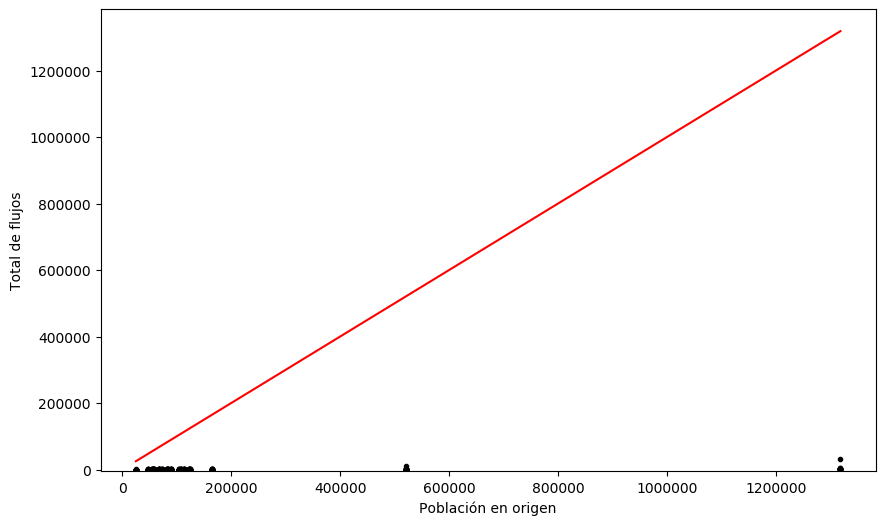

In [90]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['pob_origen'], datos_diadas['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pob_origen'].min(), datos_diadas['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, datos_diadas['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'PBI en destino')

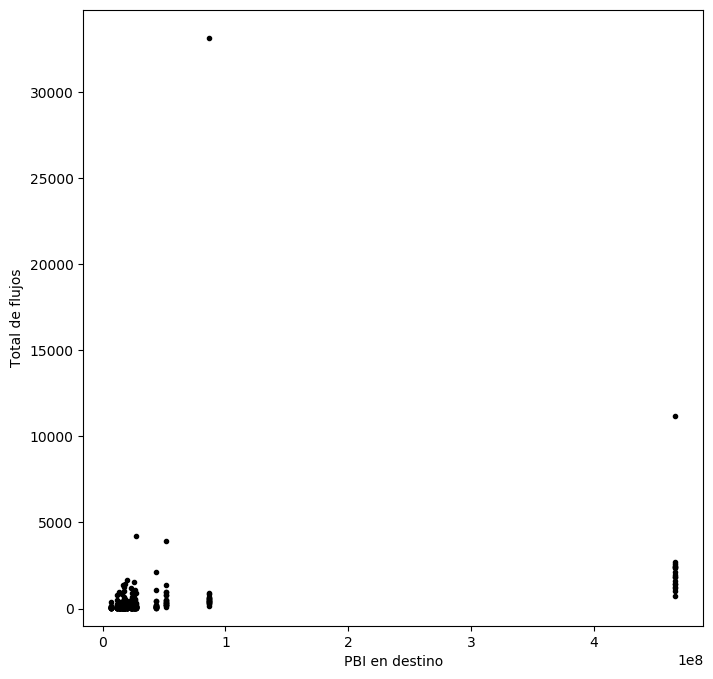

In [91]:
# Plot dePBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(datos_diadas['pbi_destino'], datos_diadas['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pbi_destino'].min(), datos_diadas['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, datos_diadas['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

# Modelo restringido en origen

$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$


$O_{i} = \sum_{j}T_{ij}$


$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$


In the production-constrained model, $O_{i}$ does not have a parameter as it is a known constraint, although it could be dissaggregated and receive a superscript index. $A_{i}$ is known as a balancing factor and is a vector of values which relate to each origin, $i$, which do a similar job to $k$ in the unconstrained/total constrained model. Specifically, $A_{i}$ ensures that flow estimates from each origin sum to the known totals, $O_{i}$ rather than just the overall total. This constraint is given by equation 2 above.

En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$


Now at this point, we could calculate all of the $O_{i}$s and $A_{i}$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python, Statsmodels and the Poisson GLM to do this work for us!

We set about re-specifying the Production-Constrained model as a Poisson regression model in a similar way to how we did before. We need to take logs of the right-hand side of equation and assume that these are logarithmially linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. Equation 1 (above) then becomes:


$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$



In [92]:
# Run a production constrained SIM using a Poisson GLM.
# We'll do this using statsmodels, and the formula approach.
# Here we're just using the 7 borough sub sample of data.
# First take logs of the relevant fields



Ejemplo de modelo con restricción en el origen

In [93]:
# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.

formula = "personas_mig ~ depto_origen + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      339
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73650.
Date:                Sat, 06 Jun 2020   Deviance:                   1.4507e+05
Time:                        17:02:40   Pearson chi2:                 2.03e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
depto_origen       -0.1281      0.001   -213.687      0.000      -0.129      -0.127
log_pbi_destino     0.8459      0.001    826.943      0.000       0.844       0.848
log_dist           -0.6387      0.002   -382.813      0.000      -0.642      -0.635
===================================================================================
"""

So, what do we have from this model?

The $\alpha$ parameter related to destination attractiveness is 0.8653

The $\beta$ distance decay parameter is -0.66

The 'coef' for each origin (given here as OrigNewCode[code]) is the logged $A_{i}O_{i}$ value for that origin.

# Model estimates

In [94]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

In [95]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# Rename index values associated with geographies so I can merge the values with cdatasub

# This approach uses a regex pattern that replaces all values with '' unless they are in the set E0123456789
# mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^E0123456789]','').values)),inplace=True)
# An easier approach is to simply subset the strings using a list comprehension.
#mu_i.rename(index = dict(zip(mu_i.index[:-2].values,[x[12:-1] for x in mu_i.index[:-2].values])))

# Set column name to mu_I
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# Now merge
datos_diadas = datos_diadas.merge(mu_i, left_on='depto_origen', right_index=True)
cdatasub.head()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
mu_i

In [ ]:
datos_diadas.head()


In [ ]:
#!jupyter nbconvert --to html --no-input 02-metodologia.ipynb 